## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [286]:
import math
import numpy as np

In [287]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
  c0 = 0
  c1 = 0
  for s in sequence: 
    if s == 1:
      c1 += 1
    else:
      c0 += 1

  g = 1
  n = len(sequence)
  p0 = c0 / n
  p1 = c1 / n
  g = g - p0**2 - p1**2
  return g


def entropy(sequence):
  c0 = 0
  c1 = 0
  for s in sequence: 
    if s == 1:
      c1 += 1
    else:
      c0 += 1
  if c0 == 0 or c1 == 0:
    return 0
  else:
    e = 0
    n = len(sequence)
    p0 = float(c0 / n)
    p1 = float(c1 / n)
    e = e - p0 * math.log(p0, 2) - p1 * math.log(p1, 2)
    return e

In [288]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [289]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [290]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [291]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [292]:
import pandas as pd
# /content/drive/MyDrive/dataset/IMDB
train_df = pd.read_csv('/content/drive/MyDrive/ML/HW3/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ML/HW3/val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


In [293]:
x_train = train_df.drop(labels=["price_range"], axis="columns")
feature_names = x_train.columns.values
# print(feature_names)
x_train = x_train.values
y_train = train_df['price_range'].values

In [294]:
x_test = val_df.drop(labels=["price_range"], axis="columns")
x_test = x_test.values
y_test = val_df['price_range'].values

In [295]:
def accuracy(truth, pred):
  correct = 0
  for i in range(len(pred)):
    if pred[i] == truth[i]:
      correct += 1
  acc = correct / len(truth)

  return acc

## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [296]:
class Node:
  def __init__(self, column=None, threshold=None, true_branch=None, false_branch=None, value=None, leaf=False):
    self.column = column
    self.threshold = threshold
    # decision tree
    self.true_branch = true_branch
    self.false_branch = false_branch
    self.value = value
    self.leaf = leaf # check if is leaf

In [297]:
def calcProbs(y_data):
  ''' Calculates probability of class in a given node '''
  c0 = 0
  c1 = 0
  for y in y_data: 
    if y == 1:
      c1 += 1
    else:
      c0 += 1

  n = len(y_data)
  p0 = float(c0 / n)
  p1 = float(c1 / n)
  probs = np.asarray([p0, p1])
  
  return probs

In [298]:
# condition: > / <=
class DecisionTree():
  def __init__(self, criterion='gini', max_depth=None, max_features=None):
    self.max_depth = max_depth
    self.criterion = criterion
    self.Tree = None
    # adaboost
    self.polarity = None
    self.alpha = None
    # random forest
    self.max_features = max_features

  def calcImpurity(self, y_data):
    ''' decide which criterion to use '''
    if self.criterion == 'gini':
      impurity = gini(y_data)
    elif self.criterion == 'entropy':
      impurity = entropy(y_data)

    return impurity
  
  def findBestSplit(self, x_data, y_data, col_idxs):
    ''' find the best split '''
    best_gain = -10  # keep track of the best information gain 
    best_col = None
    best_thresh = None
    current_impurity = self.calcImpurity(y_data)

    # for each column in x
    for col in col_idxs:
      x_col = x_data[:, col]
      values = np.unique(x_col) # accelerate
      # for each value in the column
      for value in values:
        threshold = value
        y_true = y_data[x_col > threshold]
        y_false = y_data[x_col <= threshold]
        
        # Skip this split if it doesn't divide the dataset.
        if len(y_true) == 0 or len(y_false) == 0:
          continue
            
        # calculate impurity for branches
        impurityTrue = self.calcImpurity(y_true)
        impurityFalse = self.calcImpurity(y_false)
        
        # calculate information gain
        info_gain = current_impurity
        info_gain -= impurityTrue * y_true.shape[0] / y_data.shape[0]
        info_gain -= impurityFalse * y_false.shape[0] / y_data.shape[0]
        
        if info_gain >= best_gain:
          best_col = col
          best_thresh = threshold
          best_gain = info_gain

    # random forest side effect
    if best_col is None:
      return None, None, None, None, None, None

    # making the best split
    x_col = x_data[:, best_col]
    x_true, x_false = x_data[x_col > best_thresh, :], x_data[x_col <= best_thresh, :]
    y_true, y_false = y_data[x_col > best_thresh], y_data[x_col <= best_thresh]
    
    return best_col, best_thresh, x_true, y_true, x_false, y_false
  
  def buildTree(self, x_data, y_data, depth, node):
    if self.max_depth is not None:
      if depth > self.max_depth:
        node.leaf = True
        return
    # consist of only one class
    if len(np.unique(y_data)) == 1:
      node.leaf = True
      return

    n_features = x_data.shape[1]
    if self.max_features is None:
      col_idxs = np.arange(n_features)
    else: # random forest 
      col_idxs = np.random.choice(n_features, self.max_features, replace=False)

    split_col, threshold, x_true, y_true, x_false, y_false = self.findBestSplit(x_data, y_data, col_idxs)
    # random forest side effect
    if split_col is None:
      node.leaf = True # root is leaf
      return
  
    node.column = split_col
    node.threshold = threshold
    node.true_branch = Node()
    node.true_branch.value = calcProbs(y_true)
    node.false_branch = Node()
    node.false_branch.value = calcProbs(y_false)

    # splitting recursevely
    true_branch = self.buildTree(x_true, y_true, depth + 1, node.true_branch)
    false_branch = self.buildTree(x_false, y_false, depth + 1, node.false_branch)
    return Node(column=split_col, threshold=threshold, true_branch=true_branch, false_branch=false_branch)
  
  def fit(self, x_data, y_data):
    ''' run training '''
    prob = calcProbs(y_data)
    # root node
    self.Tree = Node(value=prob)
    # random forest
    if self.max_features is not None:
      self.max_features = math.floor(self.max_features)
    self.buildTree(x_data, y_data, 1, self.Tree)

  def traverse(self, x, node):
    if node.leaf:
      return node.value

    if x[node.column] > node.threshold:
      probs = self.traverse(x, node.true_branch)
    else:
      probs = self.traverse(x, node.false_branch)
    
    return probs

  def predict(self, x_data):
    ''' Returns the labels for each x_data '''
    y_pred = []
    for x in x_data:
      probs = self.traverse(x, self.Tree)
      pred = np.argmax(probs)
      y_pred.append(pred)
    
    return np.asarray(y_pred)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [299]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [300]:
clf_depth3.fit(x_train, y_train)
clf_depth10.fit(x_train, y_train)

In [301]:
CART3 = clf_depth3.predict(x_test)
CART10 = clf_depth10.predict(x_test)
print('criterion=gini')
print(f'max_depth=3: {accuracy(y_test, CART3)}')
print(f'max_depth=10: {accuracy(y_test, CART10)}')

criterion=gini
max_depth=3: 0.9166666666666666
max_depth=10: 0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [302]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [303]:
clf_gini.fit(x_train, y_train)
clf_entropy.fit(x_train, y_train)

In [304]:
CART_gini = clf_gini.predict(x_test)
CART_entropy = clf_entropy.predict(x_test)
print(f'criterion=gini: {accuracy(y_test, CART_gini)}')
print(f'criterion=entropy: {accuracy(y_test, CART_entropy)}')

criterion=gini: 0.9166666666666666
criterion=entropy: 0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [305]:
import matplotlib.pyplot as plt

In [306]:
class FeatureImportance():
  def __init__(self):
    self.counts = np.zeros(len(feature_names))

  def calc(self, node):
    if node.leaf:
      return
    self.counts[node.column] += 1
    self.calc(node.true_branch)
    self.calc(node.false_branch)

  def ret(self, node):
    self.calc(node)
    return self.counts

In [307]:
feature_importance = FeatureImportance()
counts = feature_importance.ret(clf_depth10.Tree)
print(counts)

[ 8.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0. 10.  5.  9.  3.  0.  5.  0.
  1.  3.]


In [308]:
df = pd.DataFrame ({ 
    'Header': feature_names,
    'Value': counts
})
df = df.sort_values(by=['Value'])

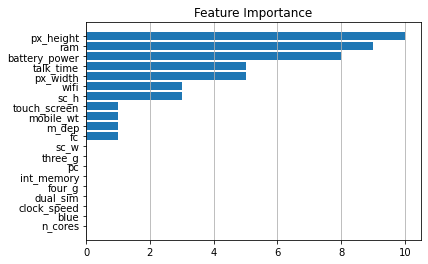

In [309]:
plt.title('Feature Importance')
plt.barh(y=df.Header, width=df.Value, height=0.8)
plt.grid(axis='x')
plt.show()

## Question 4
implement the AdaBoost algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBoost.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [310]:
from tqdm import tqdm

In [311]:
# condition: > / <=
class AdaBoost():
  def __init__(self, n_estimators):
    self.n_estimators = n_estimators

  def relabel(self, y_data):
    y_updated = y_data.copy()
    for i in range(len(y_updated)):
      if y_updated[i] == 0:
        y_updated[i] = -1

    return y_updated

  def fit(self, x_data, y_data):
    samples, features = x_data.shape
    y_relabeled = self.relabel(y_data)
    # Initialize distribution to 1/N
    distribution = np.full(samples, (1 / samples))

    self.clfs = []
    for n in tqdm(range(self.n_estimators)):
      clf = DecisionTree(max_depth=1)
      clf.Tree = Node()
      min_error = float('inf')
      for col in range(features):
        x_col = x_data[:, col]
        for value in x_col:
          threshold = value
          # init polarity to 1
          polarity = 1

          pred = np.zeros(y_relabeled.shape)
          pred[x_col >= threshold] = 1
          pred[x_col < threshold] = -1
          # Error = sum of distribution of misclassified samples
          misclassified = distribution[y_relabeled != pred]
          error = sum(misclassified)

          # inverse
          if error > 0.5:
            error = 1 - error
            polarity = -1
  
          if error < min_error:
            clf.polarity = polarity
            clf.column = col
            clf.threshold = threshold
            min_error = error

      # calculate alpha
      clf.alpha = 0.5 * np.log((1.0 - min_error) / (min_error))

      # calculate predictions and update distribution
      pred = self.traverse(x_data, clf)
      distribution *= np.exp(-clf.alpha * y_relabeled * pred)
      distribution /= np.sum(distribution) # normalize

      self.clfs.append(clf)

  def traverse(self, x_data, node):
    n_samples = x_data.shape[0]
    x_col = x_data[:, node.column]
    predictions = np.zeros(n_samples)
    # -1 for class 0, 1 for class 1
    if node.polarity == 1:
      predictions[x_col >= node.threshold] = 1
      predictions[x_col < node.threshold] = -1
    else:
      predictions[x_col >= node.threshold] = -1
      predictions[x_col < node.threshold] = 1

    return predictions

  def predict(self, x_data):
    clf_preds = [] # record every classifier's result
    for clf in self.clfs:
      record = clf.alpha * self.traverse(x_data, clf)
      clf_preds.append(record)
    y_pred = np.sum(clf_preds, axis=0)
    for i in range(len(y_pred)):
      if y_pred[i] > 0:
        y_pred[i] = 1
      else:
        y_pred[i] = 0

    return np.asarray(y_pred)

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [312]:
clf_10estimator = AdaBoost(n_estimators=10)
clf_100estimator = AdaBoost(n_estimators=100)

In [313]:
clf_10estimator.fit(x_train, y_train)
clf_100estimator.fit(x_train, y_train)

100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


In [314]:
AdaBoost10 = clf_10estimator.predict(x_test)
AdaBoost100 = clf_100estimator.predict(x_test)
print('AdaBoost')
print(f'n_estimators=10: {accuracy(y_test, AdaBoost10)}')
print(f'n_estimators=100: {accuracy(y_test, AdaBoost100)}')

AdaBoost
n_estimators=10: 0.94
n_estimators=100: 0.9733333333333334


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [315]:
class RandomForest():
  def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
    self.n_estimators = n_estimators
    self.max_features = max_features
    self.boostrap = boostrap
    self.criterion = criterion
    self.max_depth = max_depth

  def bootstrap(self, x_data, y_data):
    n_samples = x_data.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return x_data[idxs], y_data[idxs]

  def vote(self, y_data):
    major = np.bincount(y_data).argmax()
    return major

  def fit(self, x_data, y_data):
    self.trees = []
    for n in tqdm(range(self.n_estimators)):
      tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
      x_sample, y_sample = self.bootstrap(x_data, y_data)
      tree.fit(x_sample, y_sample)
      self.trees.append(tree)

  def predict(self, x_data):
    tree_preds = []
    for tree in self.trees:
      pred = tree.predict(x_data)
      tree_preds.append(pred)
    # [1111 0000 1111] to [101 101 101 101]
    tree_preds = np.swapaxes(tree_preds, 0, 1)
    y_pred = []
    for tree_pred in tree_preds:
      result = self.vote(tree_pred)
      y_pred.append(result)
    return np.asarray(y_pred)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [316]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [317]:
clf_10tree.fit(x_train, y_train)
clf_100tree.fit(x_train, y_train)

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [318]:
RandomForest10 = clf_10tree.predict(x_test)
RandomForest100 = clf_100tree.predict(x_test)
print('RandomForest')
print(f'n_estimators=10: {accuracy(y_test, RandomForest10)}')
print(f'n_estimators=100: {accuracy(y_test, RandomForest100)}')

n_estimators=10: 0.9233333333333333
n_estimators=100: 0.94


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [319]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [320]:
clf_random_features.fit(x_train, y_train)
clf_all_features.fit(x_train, y_train)

100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


In [321]:
RandomFeatures = clf_random_features.predict(x_test)
AllFeatures = clf_all_features.predict(x_test)
print(f'max_features=sqrt(n_features): {accuracy(y_test, RandomFeatures)}')
print(f'max_features=n_features: {accuracy(y_test, AllFeatures)}')

max_features=sqrt(n_features): 0.9366666666666666
max_features=n_features: 0.9733333333333334


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [322]:
def train_your_model(data):
  ## Define your model and training
  xdata = data.drop(labels=["price_range"], axis="columns")
  xdata = xdata.values
  ydata = data['price_range'].values

  model = RandomForest(n_estimators=100, max_features=xdata.shape[1], criterion='entropy', max_depth=10)
  model.fit(xdata, ydata)
  return model

In [323]:
trainval_df = pd.concat([train_df, val_df],axis=0, ignore_index=True)
# print(trainval_df)

In [324]:
my_model = train_your_model(trainval_df)

100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


In [325]:
x_test = pd.read_csv('/content/drive/MyDrive/ML/HW3/x_test.csv')
x_test = x_test.values

In [326]:
y_pred = my_model.predict(x_test)

In [327]:
print(y_pred.shape)

(500,)


In [328]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [329]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: ignored

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")
